In [1]:
import os
import pandas as pd 
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms

from torch.utils.data import Dataset
from PIL import Image
import glob

from torchvision import models
import tqdm

import time
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision.transforms import Resize, Compose, ToPILImage, ToTensor
import  torchvision.transforms.functional as TF
import pickle
import math

from efficientnet_pytorch import EfficientNet

from kornia.filters import SpatialGradient

import random
from torchvision.transforms import RandomCrop

In [2]:
class MonocularDepthDataset(Dataset):
    def __init__(self, df, transform=None, crop_size=220):
        self.df = df
        self.transform = transform
        self.crop_size = crop_size

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_path = self.df.iloc[idx]['image']
        depth_path = self.df.iloc[idx]['depth']

        image = Image.open(image_path).convert('RGB')
        depth = Image.open(depth_path)

        # randomly crop image and depth
        i, j, h, w = RandomCrop.get_params(image, output_size=(self.crop_size, self.crop_size))
        image = TF.crop(image, i, j, h, w)
        depth = TF.crop(depth, i, j, h, w)

        if self.transform:
            image = self.transform(image)
            depth = self.transform(depth)

        return image, depth

In [3]:


def gradient_loss_fn(gen_frames, gt_frames, alpha=1):
    def gradient(x):
        # idea from tf.image.image_gradients(image)
        # https://github.com/tensorflow/tensorflow/blob/r2.1/tensorflow/python/ops/image_ops_impl.py#L3441-L3512
        # x: (b,c,h,w), float32 or float64
        # dx, dy: (b,c,h,w)

        h_x = x.size()[-2]
        w_x = x.size()[-1]
        # gradient step=1
        left = x
        right = F.pad(x, [0, 1, 0, 0])[:, :, :, 1:]
        top = x
        bottom = F.pad(x, [0, 0, 0, 1])[:, :, 1:, :]

        # dx, dy = torch.abs(right - left), torch.abs(bottom - top)
        dx, dy = right - left, bottom - top 
        # dx will always have zeros in the last column, right-left
        # dy will always have zeros in the last row,    bottom-top
        dx[:, :, :, -1] = 0
        dy[:, :, -1, :] = 0

        return dx, dy

    # gradient
    gen_dx, gen_dy = gradient(gen_frames)
    gt_dx, gt_dy = gradient(gt_frames)
    #
    grad_diff_x = torch.abs(gt_dx - gen_dx)
    grad_diff_y = torch.abs(gt_dy - gen_dy)

    # condense into one tensor and avg
    return torch.mean(grad_diff_x ** alpha + grad_diff_y ** alpha)

class DepthEstimationLoss(nn.Module):
    def __init__(self, alpha=0.5):
        super(DepthEstimationLoss, self).__init__()
        self.alpha = alpha


    def forward(self, pred_depth, true_depth):
        pred_depth = torch.clamp(pred_depth, min=1e-8)
        true_depth = torch.clamp(true_depth, min=1e-8)

        # Scale-invariant MSE loss
        diff = torch.log(pred_depth) - torch.log(true_depth)
        mse_loss = torch.mean(diff**2)
        scale_invariant_mse_loss = mse_loss - (self.alpha * (torch.sum(diff)**2)) / (true_depth.numel()**2)

    

        gradient_loss = gradient_loss_fn(pred_depth,true_depth,alpha=self.alpha)

        total_loss = (scale_invariant_mse_loss + gradient_loss)/2

        return total_loss

In [4]:
class depth_model(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super(depth_model, self).__init__()
        self.base_model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=num_classes)

        self.num_classes = num_classes
        
        # Encoder layers (downsampling)
        self.encoder1 = self.base_model._conv_stem
        self.encoder2 = self.base_model._blocks[:2]
        self.encoder3 = self.base_model._blocks[2:5]
        self.encoder4 = self.base_model._blocks[5:12]
        self.encoder5 = self.base_model._blocks[12:]
        
        # Decoder layers (upsampling)
        self.decoder1 = self.decoder_block(320, 256)
        self.decoder2 = self.decoder_block(256, 128)
        self.decoder3 = self.decoder_block(128, 64)
        self.decoder4 = self.decoder_block(64, 32)
        
        # Output layers for each decoder stage
        self.output1 = nn.Conv2d(256, num_classes, kernel_size=1)
        self.output2 = nn.Conv2d(128, num_classes, kernel_size=1)
        self.output3 = nn.Conv2d(64, num_classes, kernel_size=1)
        self.output4 = nn.Conv2d(32, num_classes, kernel_size=1)

    def decoder_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(out_channels, out_channels, kernel_size=2, stride=2)
        )

    def forward(self, x):
        # Encoder
        e1 = self.encoder1(x)
        e2 = self._encode_block(e1, self.encoder2)
        e3 = self._encode_block(e2, self.encoder3)
        e4 = self._encode_block(e3, self.encoder4)
        e5 = self._encode_block(e4, self.encoder5)
        
        # Decoder
        #print(self.decoder1(e5).shape,e4.shape)
        d1 = self.decoder1(e5)
        d1 = self.resize_and_add(d1, e4)
        d2 = self.decoder2(d1)
        d2 = self.resize_and_add(d2, e3)
        d3 = self.decoder3(d2)
        d3 = self.resize_and_add(d3, e2)
        d4 = self.decoder4(d3)
        d4 = self.resize_and_add(d4, e1)
        
        # Output for each decoder stage
        out1 = self.output1(d1)
        out2 = self.output2(d2)
        out3 = self.output3(d3)
        out4 = self.output4(d4)

        # Resize output to the same shape
        H, W = x.size(2), x.size(3)
        out1 = F.interpolate(out1, size=(H, W), mode='bilinear', align_corners=False)
        out2 = F.interpolate(out2, size=(H, W), mode='bilinear', align_corners=False)
        out3 = F.interpolate(out3, size=(H, W), mode='bilinear', align_corners=False)
        out4 = F.interpolate(out4, size=(H, W), mode='bilinear', align_corners=False)
        
        # Output: average of all the outputs
        out_avg = (out1 + out2 + out3 + out4) / 4.0

        return out1, out2, out3, out4, out_avg


    def _encode_block(self, x, block):
        for layer in block:
            x = layer(x)
        return x
    
    def resize_and_add(self, x1, x2):
        x1_size = (x2.size(2), x2.size(3))
        x1_resized = F.interpolate(x1, size=x1_size, mode='bilinear', align_corners=False)
        return x1_resized + x2


In [5]:
def conv_relu_block(in_channel,out_channel,kernel,padding):
    return nn.Sequential(
            nn.Conv2d(in_channel,out_channel, kernel_size = kernel, padding=padding),
            nn.ReLU()) #nn.ReLU(inplace=True) #nn.Ge

In [47]:
class resmnet(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        
        import torch.nn as nn

        self.pool = nn.AvgPool2d(kernel_size=2)


        self.input_1 = conv_relu_block(3, 64, 3, 1)
        self.input_2 = conv_relu_block(64, 64, 3, 1)

        self.base_model = models.resnet18(pretrained=True)
        self.base_layers = list(self.base_model.children())
        
        self.block0_1_conv = conv_relu_block(67,64,1,0)
        self.block2_conv = conv_relu_block(131,128,1,0)

        
        self.l0 = nn.Sequential(*self.base_layers[:3])
        self.U0_conv = conv_relu_block(64, 64, 1, 0)
        self.conv_up0 = conv_relu_block(64 + 256, 128, 3, 1)

        self.l1 = nn.Sequential(*self.base_layers[3:5])
        self.U1_conv = conv_relu_block(64, 64, 1, 0)
        self.conv_up1 = conv_relu_block(64 + 256, 256, 3, 1)

        self.l2 = self.base_layers[5]
        self.U2_conv = conv_relu_block(128, 128, 1, 0)
        self.conv_up2 = conv_relu_block(128 + 512, 256, 3, 1)

        self.l3 = self.base_layers[6]
        self.U3_conv = conv_relu_block(256, 256, 1, 0)
        self.conv_up3 = conv_relu_block(256 + 512, 512, 3, 1)

        self.l4 = self.base_layers[7]
        self.U4_conv = conv_relu_block(512, 512, 1, 0)

        self.conv_up4 = conv_relu_block(64 + 128, 64, 3, 1)

        self.out1 = nn.Conv2d(512, n_class, 1)
        self.out2 = nn.Conv2d(256, n_class, 1)
        self.out3 = nn.Conv2d(256, n_class, 1)
        self.out4 = nn.Conv2d(128, n_class, 1)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x):
        x_one = self.input_1(x)
        x_one = self.input_2(x_one)
        
        
        scale_img_2 = self.pool(x)
        scale_img_3 = self.pool(scale_img_2)
        scale_img_4 = self.pool(scale_img_3)

        block0 = self.l0(x)
        block0 = torch.concatenate([block0,scale_img_2],axis=1)
        block0 = self.block0_1_conv(block0)

        block1 = self.l1(block0)
        block1 = torch.concatenate([block1,scale_img_3],axis=1)
        block1 = self.block0_1_conv(block1)

        block2 = self.l2(block1)
        block2 = torch.concatenate([block2,scale_img_4],axis=1)
        block2 = self.block2_conv(block2)

        #print(block2.shape)

        
        block3 = self.l3(block2)
        block4 = self.l4(block3)

        block4 = self.U4_conv(block4)
        x = self.upsample(block4)
        block3 = self.U3_conv(block3)
        x = torch.cat([x, block3], axis=1)
        x = self.conv_up3(x)
        out1 = self.out1(x)

        x = self.upsample(x)
        block2 = self.U2_conv(block2)
        x = torch.cat([x, block2], axis=1)
        x = self.conv_up2(x)
        out2 = self.out2(x)

        x = self.upsample(x)
        block1 = self.U1_conv(block1)
        x = torch.cat([x, block1], axis=1)
        x = self.conv_up1(x)
        out3 = self.out3(x)

        x = self.upsample(x)
        block0 = self.U0_conv(block0)
        x = torch.cat([x, block0], axis=1)
        x = self.conv_up0(x)
        out4 = self.out4(x)

        relu = nn.ReLU()
        out1_upsampled = F.interpolate(out1, scale_factor=16, mode='bilinear', align_corners=True)
        out2_upsampled = F.interpolate(out2, scale_factor=8, mode='bilinear', align_corners=True)
        out3_upsampled = F.interpolate(out3, scale_factor=4, mode='bilinear', align_corners=True)
        out4_upsampled = F.interpolate(out4, scale_factor=2, mode='bilinear', align_corners=True)
        
        #print("Out1 shape: ", out1_upsampled.shape)
        #print("Out2 shape: ", out2_upsampled.shape)
        #print("Out3 shape: ", out3_upsampled.shape)
        #print("Out4 shape: ", out4_upsampled.shape)
        
        out1_upsampled = relu(out1_upsampled)
        out2_upsampled = relu(out2_upsampled)
        out3_upsampled = relu(out3_upsampled)
        out4_upsampled = relu(out4_upsampled)
        
        

        avg_out = (out1_upsampled + out2_upsampled + out3_upsampled + out4_upsampled) / 4

        return out1_upsampled,out2_upsampled, out3_upsampled, out4_upsampled, avg_out

In [40]:
class resunet(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        self.input_1 = conv_relu_block(3, 64, 3, 1)
        self.input_2 = conv_relu_block(64, 64, 3, 1)

        self.base_model = models.resnet18(pretrained=True)
        self.base_layers = list(self.base_model.children())

        self.l0 = nn.Sequential(*self.base_layers[:3])
        self.U0_conv = conv_relu_block(64, 64, 1, 0)
        self.conv_up0 = conv_relu_block(64 + 256, 128, 3, 1)

        self.l1 = nn.Sequential(*self.base_layers[3:5])
        self.U1_conv = conv_relu_block(64, 64, 1, 0)
        self.conv_up1 = conv_relu_block(64 + 256, 256, 3, 1)

        self.l2 = self.base_layers[5]
        self.U2_conv = conv_relu_block(128, 128, 1, 0)
        self.conv_up2 = conv_relu_block(128 + 512, 256, 3, 1)

        self.l3 = self.base_layers[6]
        self.U3_conv = conv_relu_block(256, 256, 1, 0)
        self.conv_up3 = conv_relu_block(256 + 512, 512, 3, 1)

        self.l4 = self.base_layers[7]
        self.U4_conv = conv_relu_block(512, 512, 1, 0)

        self.conv_up4 = conv_relu_block(64 + 128, 64, 3, 1)

        self.out1 = nn.Conv2d(512, n_class, 1)
        self.out2 = nn.Conv2d(256, n_class, 1)
        self.out3 = nn.Conv2d(256, n_class, 1)
        self.out4 = nn.Conv2d(128, n_class, 1)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x):
        x_one = self.input_1(x)
        x_one = self.input_2(x_one)

        block0 = self.l0(x)
        block1 = self.l1(block0)
        block2 = self.l2(block1)
        block3 = self.l3(block2)
        block4 = self.l4(block3)

        block4 = self.U4_conv(block4)
        x = self.upsample(block4)
        block3 = self.U3_conv(block3)
        x = torch.cat([x, block3], axis=1)
        x = self.conv_up3(x)
        out1 = self.out1(x)

        x = self.upsample(x)
        block2 = self.U2_conv(block2)
        x = torch.cat([x, block2], axis=1)
        x = self.conv_up2(x)
        out2 = self.out2(x)

        x = self.upsample(x)
        block1 = self.U1_conv(block1)
        x = torch.cat([x, block1], axis=1)
        x = self.conv_up1(x)
        out3 = self.out3(x)

        x = self.upsample(x)
        block0 = self.U0_conv(block0)
        x = torch.cat([x, block0], axis=1)
        x = self.conv_up0(x)
        out4 = self.out4(x)

        out1_upsampled = F.interpolate(out1, scale_factor=16, mode='bilinear', align_corners=True)
        out2_upsampled = F.interpolate(out2, scale_factor=8, mode='bilinear', align_corners=True)
        out3_upsampled = F.interpolate(out3, scale_factor=4, mode='bilinear', align_corners=True)
        out4_upsampled = F.interpolate(out4, scale_factor=2, mode='bilinear', align_corners=True)


        avg_out = (out1_upsampled + out2_upsampled + out3_upsampled + out4_upsampled) / 4

        return out1, out2, out3, out4, avg_out



In [82]:
#model = depth_model(num_classes=1).to('cuda')
#model = resunet(n_class=1).to('cuda')
model = resmnet(n_class=1).to('cuda')

#model = effunet(n_class=1).to('cuda')

/share/pkg.7/pytorch/1.13.1/install/lib/SCC/../python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/share/pkg.7/pytorch/1.13.1/install/lib/SCC/../python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [30]:
pwd

'/projectnb/cs585bp/krishna/project'

In [12]:
cd ../../krishna/project

/projectnb/cs585bp/krishna/project


In [84]:
# Set hyperparameters, dataset paths, and other configurations
batch_size = 8
learning_rate = 0.001
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

df = pd.read_csv('train.csv')
train_dataset = MonocularDepthDataset(df, transform = transform)
#val_dataset = MonocularDepthDataset(val_image_paths, val_depth_paths, transform)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=12)
#val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


criterion = DepthEstimationLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

max_vals = []

for epoch in tqdm.tqdm_notebook(range(100)):#range(num_epochs)):
    #train_loss = train(model, train_dataloader, optimizer, criterion, device)
    
    model.train()
    running_loss = 0.0
    ctr = 0
    
    for images, depths in tqdm.tqdm_notebook(train_dataloader):
        #if ctr > 3:
        #    break
        #ctr += 1
        
        images = images.to(device)
        depths = depths.to(device)/10587
        #print(torch.max(depths).item())
        max_vals.append(torch.max(depths).item())

        optimizer.zero_grad()

        outputs = model(images)
        #print(outputs[0][0][0][0][50:55])
        #print(depths[0][0][0][50:55])
        loss = criterion(outputs[2].float(), depths.float())
        loss.backward()

        optimizer.step()
        running_loss += loss.item()
        #print('Running loss: ', running_loss)
    train_loss = running_loss / len(train_dataloader)
    print(f'Train loss on epoch {epoch} is ', train_loss)
    #val_loss = validate(model, val_dataloader, criterion, device)
#print(max(max_vals))

/scratch/7255972.1.csgpu/ipykernel_21630/3542437490.py:32: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm.tqdm_notebook(range(100)):#range(num_epochs)):


  0%|          | 0/100 [00:00<?, ?it/s]

/scratch/7255972.1.csgpu/ipykernel_21630/3542437490.py:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for images, depths in tqdm.tqdm_notebook(train_dataloader):


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 0 is  54.47389590740204


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 1 is  54.506350006375996


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 2 is  54.79346437113626


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 3 is  54.5422374691282


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 4 is  54.27872773579189


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 5 is  54.3815769297736


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 6 is  54.37909756387983


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 7 is  54.359982456479756


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 8 is  54.405793632779805


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 9 is  54.52497015680586


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 10 is  54.3313386951174


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 11 is  53.96615375791277


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 12 is  54.21179929801396


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 13 is  53.89742532798222


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 14 is  53.96987318992615


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 15 is  54.694703221321106


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 16 is  54.54189896583557


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 17 is  54.49348585946219


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 18 is  54.27372057097299


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 19 is  54.42727797372


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 20 is  54.21223941871098


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 21 is  54.19001589502607


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 22 is  54.23782720736095


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 23 is  54.54110557692392


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 24 is  54.73173924854824


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 25 is  54.42551927907126


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 26 is  54.57301986217499


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 27 is  54.10580779824938


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 28 is  53.97689068317413


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 29 is  54.49998046670641


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 30 is  54.40808321748461


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 31 is  54.32274201938084


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 32 is  54.54690819127219


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 33 is  54.568181088992525


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 34 is  54.609666790281025


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 35 is  54.292638063430786


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 36 is  54.35020433153425


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 37 is  54.49071383476257


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 38 is  54.16933357715607


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 39 is  54.39832786151341


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 40 is  54.4561949968338


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 41 is  54.20300834519522


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 42 is  54.61251858302525


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 43 is  54.5420675107411


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 44 is  54.254009229796274


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 45 is  54.17365348339081


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 46 is  54.324616823877605


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 47 is  54.22917854785919


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 48 is  54.34304875986917


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 49 is  54.206837926592144


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 50 is  54.3914293050766


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 51 is  54.47782121385847


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 52 is  54.49914283411844


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 53 is  54.05850843020848


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 54 is  54.423743861062185


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 55 is  54.589378459112986


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 56 is  54.1727043730872


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 57 is  54.22220037664686


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 58 is  54.3210072687694


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 59 is  54.52573810304914


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 60 is  54.53005690234048


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 61 is  54.67161767823355


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 62 is  54.15010322843279


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 63 is  54.01016877378736


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 64 is  54.34647926262447


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 65 is  54.31825964791434


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 66 is  54.3612699678966


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 67 is  54.40670166696821


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 68 is  54.34900711263929


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 69 is  54.246277162006926


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 70 is  54.37809831755502


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 71 is  54.11142039299011


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 72 is  54.52713792664664


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 73 is  54.39107838698796


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 74 is  54.10493577378137


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 75 is  54.45575131688799


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 76 is  54.57227781840733


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 77 is  54.17187854221889


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 78 is  54.49254291398184


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 79 is  54.831085545676096


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 80 is  54.36680916377476


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 81 is  54.471876399857656


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 82 is  53.9519464969635


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 83 is  54.310023290770395


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 84 is  53.82909880365644


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 85 is  54.565074699265615


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 86 is  54.39220239434923


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 87 is  54.35200910908835


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 88 is  54.39147116456713


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 89 is  54.17193170956203


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 90 is  54.55094412394932


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 91 is  54.05257643972124


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 92 is  54.411894406591145


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 93 is  54.566633445875986


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 94 is  54.29954777445112


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 95 is  54.39959456239428


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 96 is  54.25416253294264


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 97 is  54.53597744873592


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 98 is  54.501075693539214


  0%|          | 0/224 [00:00<?, ?it/s]

Train loss on epoch 99 is  54.183530126299175


In [87]:
cd ../../nkono

/projectnb/cs585bp/nkono


In [89]:
cd ./IVC_MDE

/projectnb/cs585bp/nkono/IVC_MDE


In [90]:
torch.save(model.state_dict(), 'bad_model.pt')

In [113]:
np.expand_dims(img, 0).shape

(1, 2200, 1550)

In [189]:
import numpy as np

def prediction(model, image, patch_size):
    segm_img = np.zeros(image.shape[:2])  ##this is 2d, only one channel.  do i want (x,y,1)?
    print(segm_img.shape)
    patch_w, patch_h = patch_size
    #print(patch_w,patch_h)
    patch_num=1
    for i in range(0, image.shape[0], patch_w):   #step by the width of the patch
        for j in range(0, image.shape[1], patch_h):  #step by height of patch
            #print(i, j)
            single_patch = image[i:i+patch_w, j:j+patch_h]
            single_patch_shape = single_patch.shape[:2]
            single_patch_input = np.expand_dims(single_patch, 0)
            single_patch_input = np.rollaxis(single_patch_input,3,1)
            print(single_patch_input.shape) #b x c x w x h
            print(single_patch.shape)
            #single_patch_prediction = (model.predict(single_patch_input)[0,:,:,0] > 0.5).astype(np.uint8)
            ##do the model inference here
            inp = torch.tensor(single_patch_input).float().to(device)
            
            try:
                out = model.forward(inp)
            except:
                return segm_img
            
            #this is temp for testing.
            #single_patch_prediction = model.forward(single_patch_input)
            #print(single_patch.shape)
            single_patch_prediction = out[2].squeeze().to('cpu').detach().numpy()
            print(out[2])

            segm_img[i:i+patch_w, j:j+patch_h] = single_patch_prediction

            #print("Finished processing patch number ", patch_num, " at position ", i,j)
            patch_num+=1
    return segm_img

In [93]:
pip install opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 MB 40.1 MB/s eta 0:00:00m eta 0:00:010:01:01
Note: you may need to restart the kernel to use updated packages.


In [94]:
import cv2

In [100]:
print(images.shape)

train_path = '../../krishna/project/train.csv'
train_csv = pd.read_csv(train_path)
train_csv.head(1)

torch.Size([2, 3, 256, 256])


,image,depth
0,inputs/620c2486c4e548989ff754784b919f0b-162490...,depth_annotations/620c2486c4e548989ff754784b91...


In [102]:
train_csv.columns

Index(['image', 'depth'], dtype='object')

In [126]:
image = cv2.imread('../../krishna/project/' + train_csv['image'][0])
depth = cv2.imread('../../krishna/project/' + train_csv['depth'][0])
image.shape

(2200, 1550, 3)

In [190]:
#img = np.array(image)
#img = np.expand_dims(img, 0)
#img = np.expand_dims(img, 0)
#print(img.shape)
patch_size = (256, 256)
output = prediction(model, image, patch_size)

(2200, 1550)
(1, 3, 256, 256)
(256, 256, 3)
tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
(1, 3, 256, 256)
(256, 256, 3)
tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0',
       grad_fn=<ReluBackward0>)
(1, 3, 256, 256)
(256, 256, 3)
tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0.

0.0


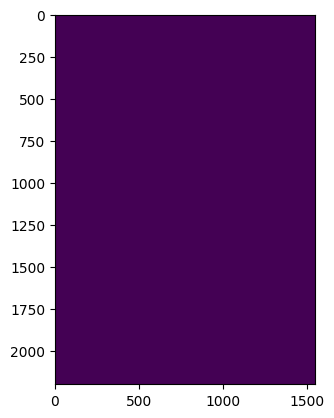

In [188]:
plt.imshow(output)
print(np.max(output))

In [138]:
pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 94.4 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 104.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 116.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.3/300.3 kB 50.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 18.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


Matplotlib is building the font cache; this may take a moment.


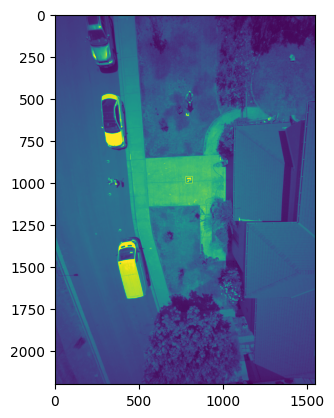

In [139]:
import matplotlib.pyplot as plt
plt.imshow(output)

In [157]:
inp = torch.ones((1, 3, 256, 256)).to(device)
out = model.forward(inp)

In [165]:
lin = out[2].squeeze()

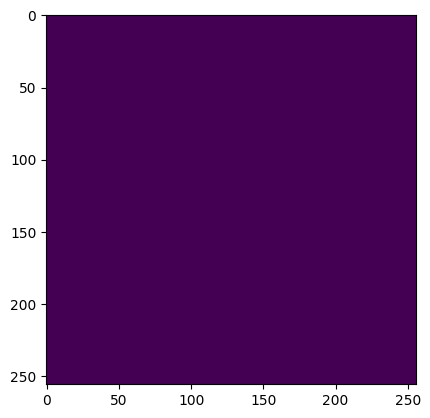

In [168]:
plt.imshow(lin.to('cpu').detach().numpy())